In [1]:
import os
import sys
import time

from ssd.ssd_vgg16 import create_ssd_vgg16
from ssd.ssd_mobilenetv1 import create_ssd_mobilenetv1
from ssd.ssd_mobilenetv1_lite import create_ssd_mobilenetv1_lite
from ssd.ssd_mobilenetv2_lite import create_ssd_mobilenetv2_lite
from ssd.pre_ssd_mobilenetv1_lite import create_pre_ssd_mobilenetv1_lite
from ssd.pre_ssd_mobilenetv2_lite import create_pre_ssd_mobilenetv2_lite
from ssd.ssd import init_ssd

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from voc_data import create_batch_generator
from anchor import generate_default_boxes
from losses import create_losses



from tqdm import tqdm
import numpy as np
import os

from anchor import generate_default_boxes
from box_utils import decode, compute_nms
from voc_data import create_batch_generator
from image_utils import ImageVisualizer
from losses import create_losses
from PIL import Image
import matplotlib.pyplot as plt

from settings import *

In [2]:
# 100 epoch당 7-8시간 소요

ARCH = 'pre_ssd300-mobilenetv2'
CHECKPOINT_DIR = 'checkpoint/pre_mobilenetv2_lite'
CHECKPOINT_PATH = 'checkpoint/pre_mobilenetv2_lite/ssd_epoch_200.h5'

os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_DETECTS_DIR, exist_ok=True)

visualizer = ImageVisualizer(IDX_TO_NAME, save_dir=OUTPUT_IMAGES_DIR)

In [3]:
default_boxes = generate_default_boxes(INFO[ARCH])
ssd = create_pre_ssd_mobilenetv2_lite()

In [4]:
pretrained_type = 'specified'
checkpoint_path = CHECKPOINT_PATH

net = init_ssd(ssd, pretrained_type, checkpoint_path)

>>> load_weights


In [5]:
from io import BytesIO
from urllib.request import urlopen

def load_img_from_url(url):
    resp = urlopen(url)

    im_src = Image.open(BytesIO(resp.read()))

    mode = im_src.mode
    if mode != 'RGB':
        img = im_src.convert('RGB')
    else:
        img = im_src

    return img

def convert_tf_img(img):
  
    img = np.array(img.resize(
          (SIZE, SIZE)), dtype=np.float32)
    img = (img / 127.0) - 1.0
    tf_img = tf.constant(img, dtype=tf.float32)
    tf_img = img[tf.newaxis, ...]

    return tf_img

def show_imgs(imgs):
    count = len(imgs)
    i = 100 + count * 10
    for img in imgs:
        i += 1
        plt.subplot(i)
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    pass

## VOC DATA batch Test

In [6]:
def predict(confs, locs, default_boxes):

    confs = tf.math.softmax(confs, axis=-1)
    classes = tf.math.argmax(confs, axis=-1)
    scores = tf.math.reduce_max(confs, axis=-1)

    boxes = decode(default_boxes, locs)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, NUM_CLASSES):
        cls_scores = confs[:, c]

        score_idx = cls_scores > CLS_SCORE

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores, NMS_THRESHOLD, 200)
        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)
        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

## Load batch imgs

In [7]:
# arr_img_path = ['dataset/VOC2012/JPEGImages/2007_000063.jpg', 'dataset/VOC2012/JPEGImages/2007_000032.jpg']
arr_img_path = ['dataset/VOC2012/JPEGImages/2009_004651.jpg']

arr_imgs = []
arr_tf_imgs = []

# img read
for img_path in arr_img_path:
    img = Image.open(img_path)
    arr_imgs.append(img)
    
    tf_img = convert_tf_img(img)
    arr_tf_imgs.append(tf_img)

# transform_list_to_tensor
arr_tf_imgs = tf.convert_to_tensor(arr_tf_imgs)
arr_tf_imgs = tf.squeeze(arr_tf_imgs, 1)

## Refine predicted imgs

In [8]:
# predict imgs
arr_confs, arr_locs = net(arr_tf_imgs)

# refine predict imgs

arr_result_imgs = []

num = 0
for confs, locs, img in zip(arr_confs, arr_locs, arr_imgs):

    boxes, classes, scores = predict(confs, locs, default_boxes)

    original_image = img
    boxes *= original_image.size * 2

    filename = '{}'.format(num) + '.jpg'

    result_img = visualizer.save_image(
      original_image, boxes, classes, '{}'.format(filename), save=False)

    arr_result_imgs.append(result_img)

    num += 1

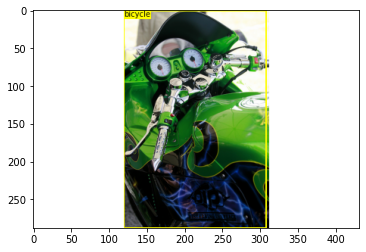

In [9]:
plt.imshow(result_img)

## Wemakeprice img URL Test

In [10]:
arr_test_url = [
            'https://view01.wemep.co.kr/wmp-deal/1/581/601975811/601975811_wide.jpg?1571990283',
            'https://view01.wemep.co.kr/wmp-deal/7/609/602636097/602636097_wide.jpg?1571990879',
            'https://view01.wemep.co.kr/wmp-deal/5/396/600163965/600163965.jpg?1571805795',
            'https://view01.wemep.co.kr/wmp-product/5/156/329111565/329111565_wide.jpg?1571992747',
            'https://view01.wemep.co.kr/wmp-deal/3/712/601357123/601357123_wide.jpg?1571992978',
            'https://view01.wemep.co.kr/wmp-product/3/164/329111643/329111643_wide.jpg?1571992751',
            'https://view01.wemep.co.kr/wmp-deal/6/917/602469176/602469176_wide.jpg?1571994818',
            'https://view01.wemep.co.kr/wmp-product/9/765/146137659/146137659.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/8/249/152982498/152982498.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/9/703/154507039/154507039.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/8/309/151943098/151943098.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/9/678/132666789/132666789.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/5/471/159514715/159514715.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/5/049/130240495/130240495.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/3/476/132664763/132664763.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/7/568/159105687/159105687.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/0/791/146297910/146297910.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/2/204/159092042/159092042.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/9/529/146085299/146085299.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/6/775/159087756/159087756.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/6/114/125111146/125111146.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/0/296/117622960/117622960.jpg?0',
            'https://view01.wemep.co.kr/wmp-deal/0/591/600005910/600005910.jpg?1554456010',
            'https://view01.wemep.co.kr/wmp-product/2/390/149803902/149803902.jpg?1551598421',
            'https://view01.wemep.co.kr/wmp-product/8/004/138550048/138550048.jpg?1551598421',
            'https://view01.wemep.co.kr/wmp-product/6/390/149803906/149803906.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/8/391/149803918/149803918.jpg?1551598423',
            'https://view01.wemep.co.kr/wmp-product/7/355/149803557/149803557.jpg?1551598154',
            'https://view01.wemep.co.kr/wmp-product/0/239/147482390/147482390.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/6/360/131773606/131773606.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/5/354/149763545/149763545.jpg?1551588022',
            'https://view01.wemep.co.kr/wmp-product/3/355/149763553/149763553.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/5/357/149763575/149763575.jpg?1551588027',
            'https://view01.wemep.co.kr/wmp-product/2/238/149752382/149752382.jpg?1551585555',
            'https://view01.wemep.co.kr/wmp-product/6/010/154320106/154320106.jpg?0',
            'https://view01.wemep.co.kr/wmp-product/0/797/153977970/153977970.jpg?0',
            'https://view01.wemep.co.kr/wmp-deal/4/293/600162934/600162934.jpg?1554443622'
]

In [11]:
# load img from url

arr_imgs = []
arr_tf_imgs = []

for num, img_url in enumerate(arr_test_url):
    img = load_img_from_url(img_url)
    tf_img = convert_tf_img(img)

    arr_imgs.append(img)
    arr_tf_imgs.append(tf_img)

# transform_list_to_tensor
arr_tf_imgs = tf.convert_to_tensor(arr_tf_imgs)
arr_tf_imgs = tf.squeeze(arr_tf_imgs, 1)

In [12]:
# predict imgs
arr_confs, arr_locs = net(arr_tf_imgs)

# refine predict imgs

arr_result_imgs = []

num = 0
for confs, locs, img in zip(arr_confs, arr_locs, arr_imgs):
    
    boxes, classes, scores = predict(confs, locs, default_boxes)
    
    original_image = img
    boxes *= original_image.size * 2

    filename = '{}'.format(num) + '.jpg'
    
    result_img = visualizer.save_image(
      original_image, boxes, classes, '{}'.format(filename), save=False)
    
    arr_result_imgs.append(result_img)
    
    num += 1

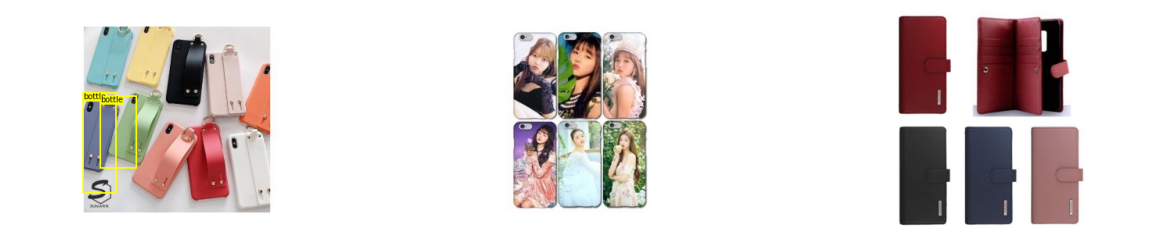

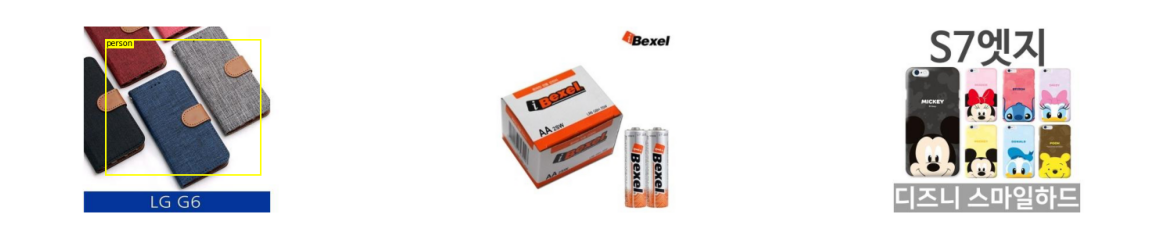

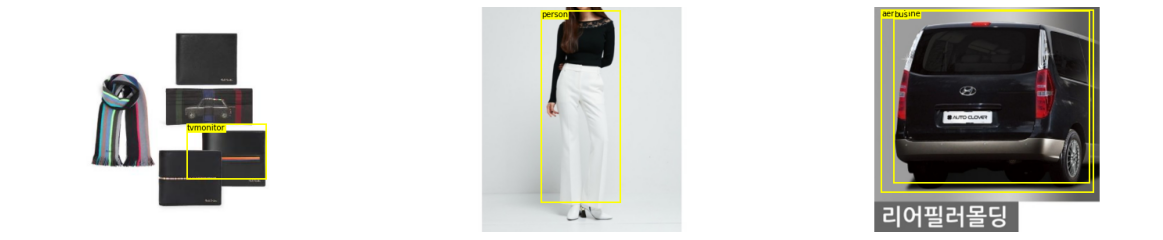

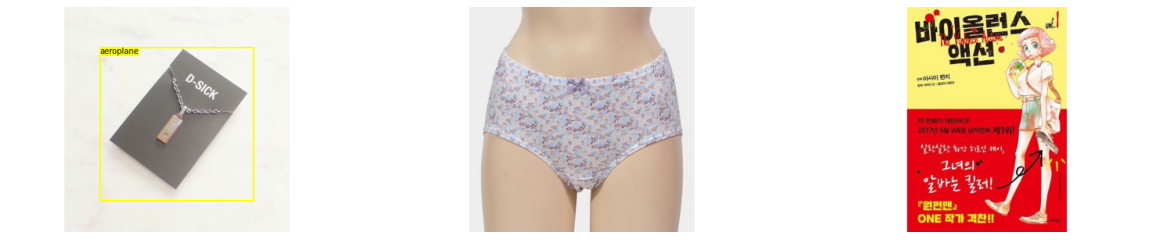

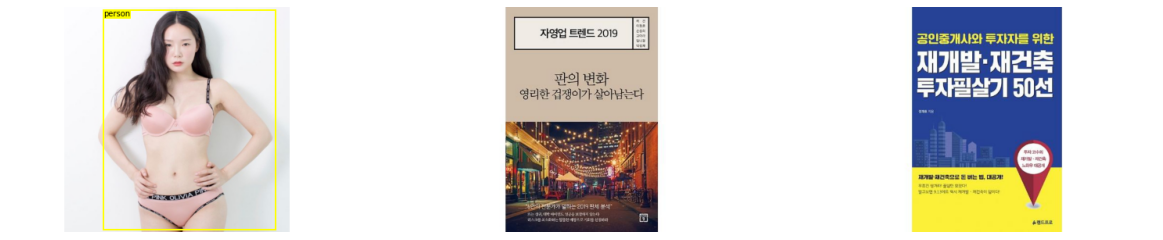

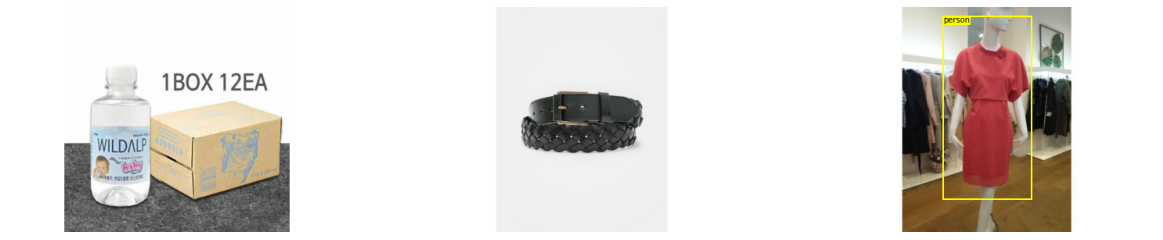

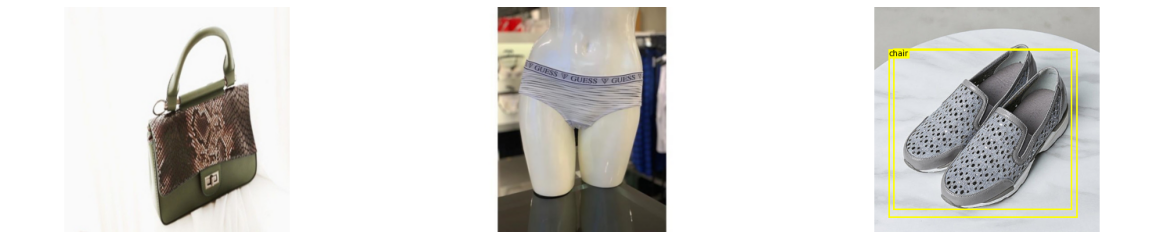

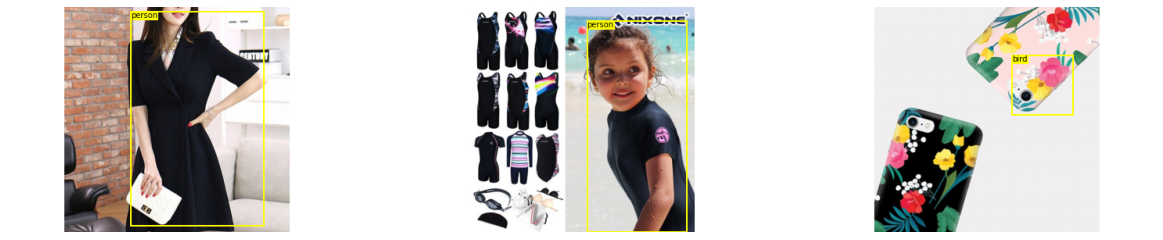

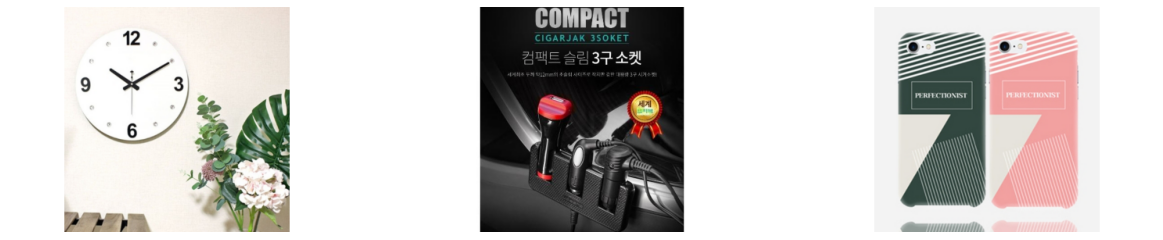

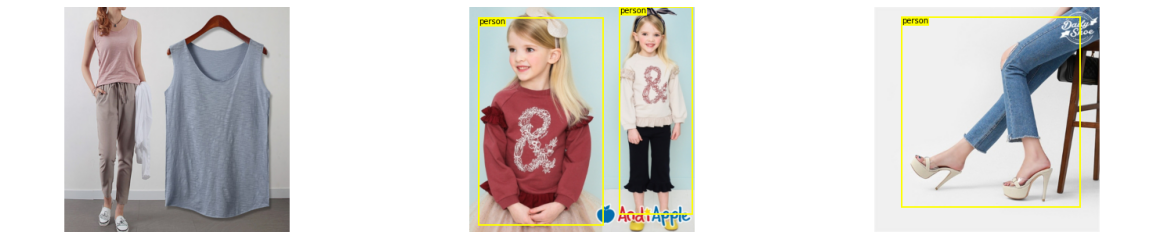

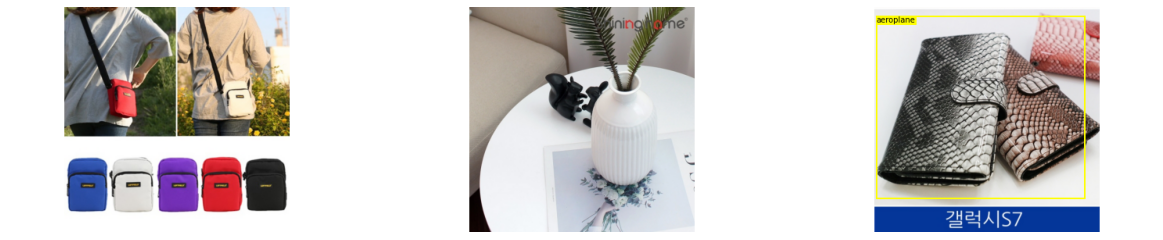

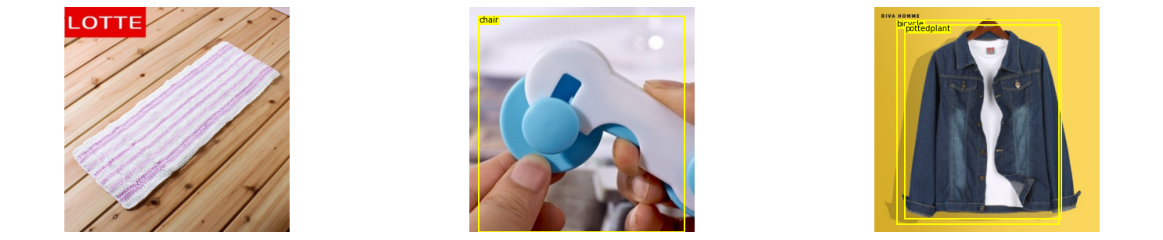

In [13]:
import cv2
import matplotlib.pyplot as plt

# im show
img_list = []

for result_img in arr_result_imgs:
    img_list.append(result_img)

    if len(img_list) % 3 == 0:
        plt.figure(figsize=(30, 20), dpi=80).set_size_inches(18.5, 10.5)
        show_imgs(img_list)
        img_list = []      